## 158p. 6.8.1. 시뮬레이션된 ARMA(1,1) 프로세스에 대한 예측 수행하기

### 1. 시뮬레이션된 ARMA(1,1) 프로세스를 재사용하여 훈련집합과 테스트 집합으로 분할 (80%/20%)



In [1]:
# 시뮬레이션
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ar1 = np.array([1,-0.33])
ma1 = np.array([1,0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [2]:
import pandas as pd
df = pd.DataFrame({'ARMA_1_1':ARMA_1_1})

train = df[:int(0.8*len(ARMA_1_1))]
test = df[int(0.8*len(ARMA_1_1)):]
print(len(train))
print(len(test))

800
200


### 2. rolling_forecast 함수를 사용하여 ARMA(1,1) 모델, 평균 방법, 마지막으로 측정된 값 방법에 의한 예측 수행

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df:pd.DataFrame, train_len: int, horizon: int,
                       window: int, method: str ) -> list:

  total_len = train_len + horizon

  # 평균값
  if method == 'mean':
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i])
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  # 마지막 값
  elif method == 'last':
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  # MA(2)
  elif method == 'ARMA':
    pred_ARMA = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(1,0,1))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean[-window:]
      pred_ARMA.extend(oos_pred)

    return pred_ARMA

In [4]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last'] = pred_last
pred_df['pred_ARMA'] = pred_ARMA

pred_df.head()

,ARMA_1_1,pred_mean,pred_last,pred_ARMA
800,1.084218,-0.022669,0.361071,0.146811
801,0.686203,-0.022669,0.361071,0.043347
802,-0.141873,-0.020405,0.686203,-0.255567
803,-0.422585,-0.020405,0.686203,-0.075349
804,-0.989997,-0.021056,-0.422585,-0.571610


### 3. 예측 도식화

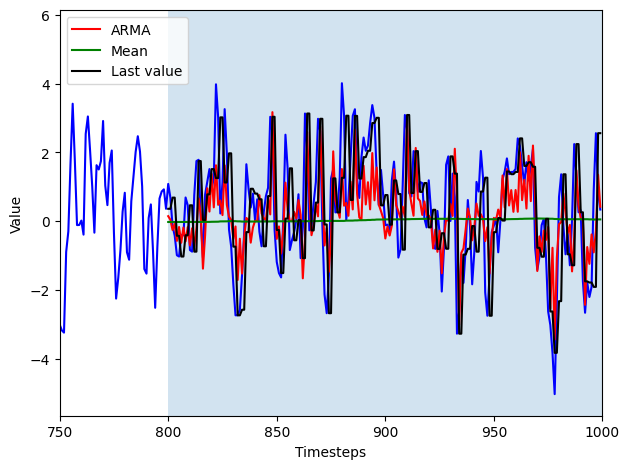

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['ARMA_1_1'], 'b-')
ax.plot(range(800,1000), pred_df['pred_ARMA'], 'r-', label='ARMA')
ax.plot(range(800,1000), pred_df['pred_mean'], 'g-', label='Mean')
ax.plot(range(800,1000), pred_df['pred_last'], 'k-', label='Last value')

ax.axvspan(len(train), len(train) + len(test), alpha=0.2)
ax.legend(loc = 2)

plt.xlim(750, 1000)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')


plt.tight_layout()

### 4. MSE 사용하여 각 방법의 성능 평가

In [6]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test, pred_df['pred_mean'])
mse_last = mean_squared_error(test, pred_df['pred_last'])
mse_ARMA = mean_squared_error(test, pred_df['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

2.6813127877824168 2.595337049559967 1.4995594450088783
